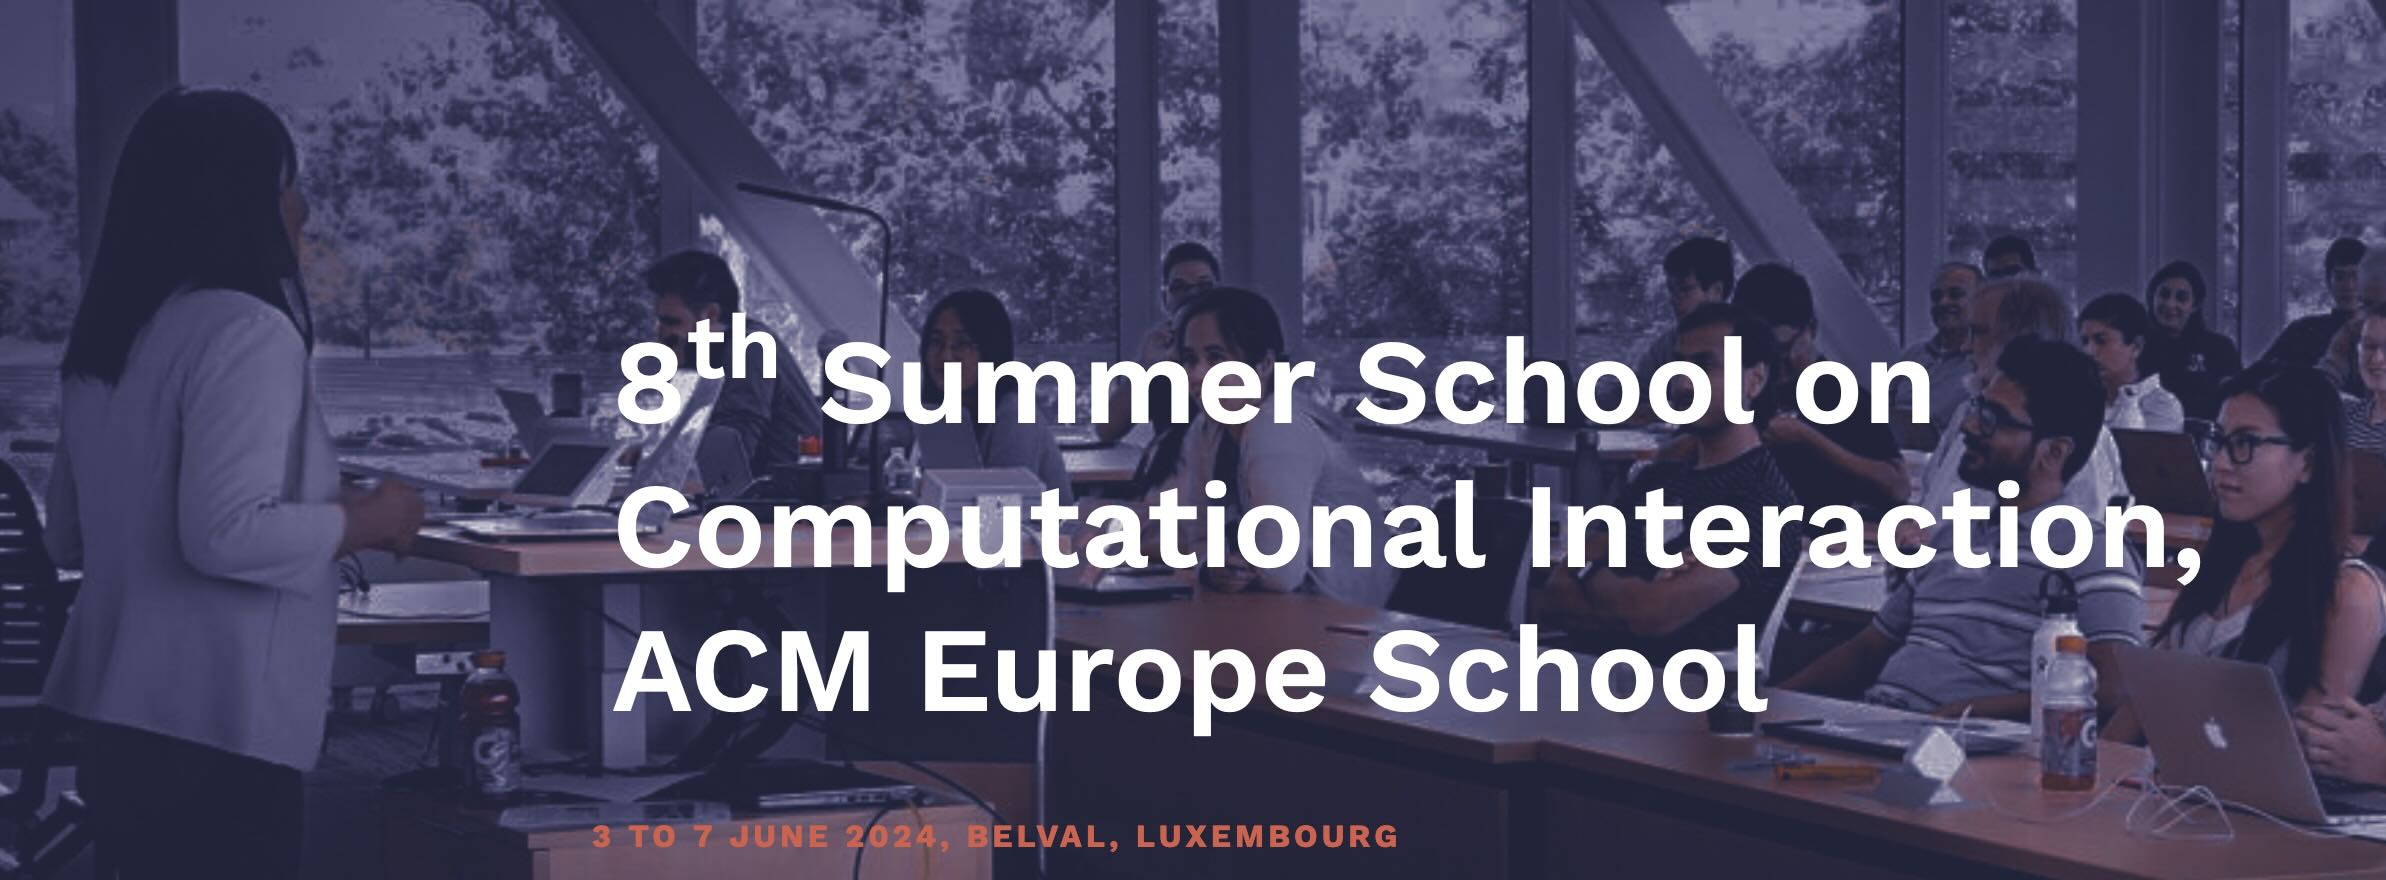

# Optimization methods to support interface design and adaptation
[João Belo](https://scholar.google.dk/citations?user=ANS7JzkAAAAJ&hl=en), [Anna Maria Feit](http://annafeit.de/) \\
[Computational Interaction Group](https://cix.cs.uni-saarland.de/) \\
Saarland University, Saarland Informatics Campus


You can run this notebook locally or on Colab: https://colab.research.google.com/drive/1nUjObTTMTtlr54OgKRDYjjKyneuaWFHy?usp=sharing
If you want to run it locally we recommend creating a new environment using Anaconda, or a similar environment manager.

This notebook introduces you to the field of combinatorial optimization and its applications in HCI. The main goal is to give you an overview of the optimization landscape in terms of what classes of methods exist, what problems they can solve, and how they can be applied to HCI problems. To get some hands on experience we will explore some specific methods in more detail.

But first let's start with some [**Motivation**](https://github.com/CIX24-UNILU/CIXSummerSchool2024/blob/616d70b16fdc41dedf14a8df164eef0fdb571ad0/Day_2_Lecture_1_Feit_Bello/CIXSchool24_Optimization_%20Motivation%20and%20Conclusion.pdf)

### In the next hours you will learn...

*   What is optimization.
*   How to formulate a design problem as an optimization problem with objectives and constraints.
*  What optimization methods there are and how to use them to solve HCI problems.
*  How to deal with multiple optimization criteria, what is the Pareto frontier, and how to compute it.



### References:
[1] Nocedal, Jorge, and Stephen J. Wright, eds. Numerical optimization. New York, NY: Springer New York, 1999.

[2] Boyd, Stephen P., and Lieven Vandenberghe. Convex optimization. Cambridge university press, 2004.

## What is optimization?
> "Optimization is an important tool in decision science and in the analysis of physical systems. To make use of this tool, we must ﬁrst identify some objective, a quantitative measure of the performance of the system under study. This objective could be proﬁt, time, potential energy, or any quantity or combination of quantities that can be represented by a single number. The objective depends on certain characteristics of the system, called variables or unknowns. Our goal is to ﬁnd values of the variables that optimize the objective." [1]

Although this is a generic definition of what optimization is, it outlines key components which are also present when optimizing for HCI problems - **variables**, **objectives**, and **solvers**.

## Formulating optimization problems
Optimization problems typically have the form [1,2]:
\begin{align*}
\text{minimize} \quad & f_0(x) \\
\text{subject to} \quad & f_i(x) \leq b_i, \quad i = 1, \ldots, m.
\end{align*}
Where:
- The $x = (x_1, ..., x_n)$ is the vector of variables of the problem;
- The function $f_0 : \mathbb{R}^n \to \mathbb{R}$ is the objective function that we want to minimize (in this case, but maximization also possible)
- The functions $f_i : \mathbb{R}^n \to \mathbb{R}$ are the constraint functions, or in other words, rules or limits that define the conditions under which the solution must be found (inequality, in this formulation; some formulations also include equality constraints, or no constraints at all).

### Optimality
A vector $x^*$ is called optimal if it has the smallest possible value for the objective function $f_0$ across all possible vectors of $x$ that respect the constraint functions $f_i$. What does this looks like in practice? Let's analyze a plotted objective function:




<div>
<img src=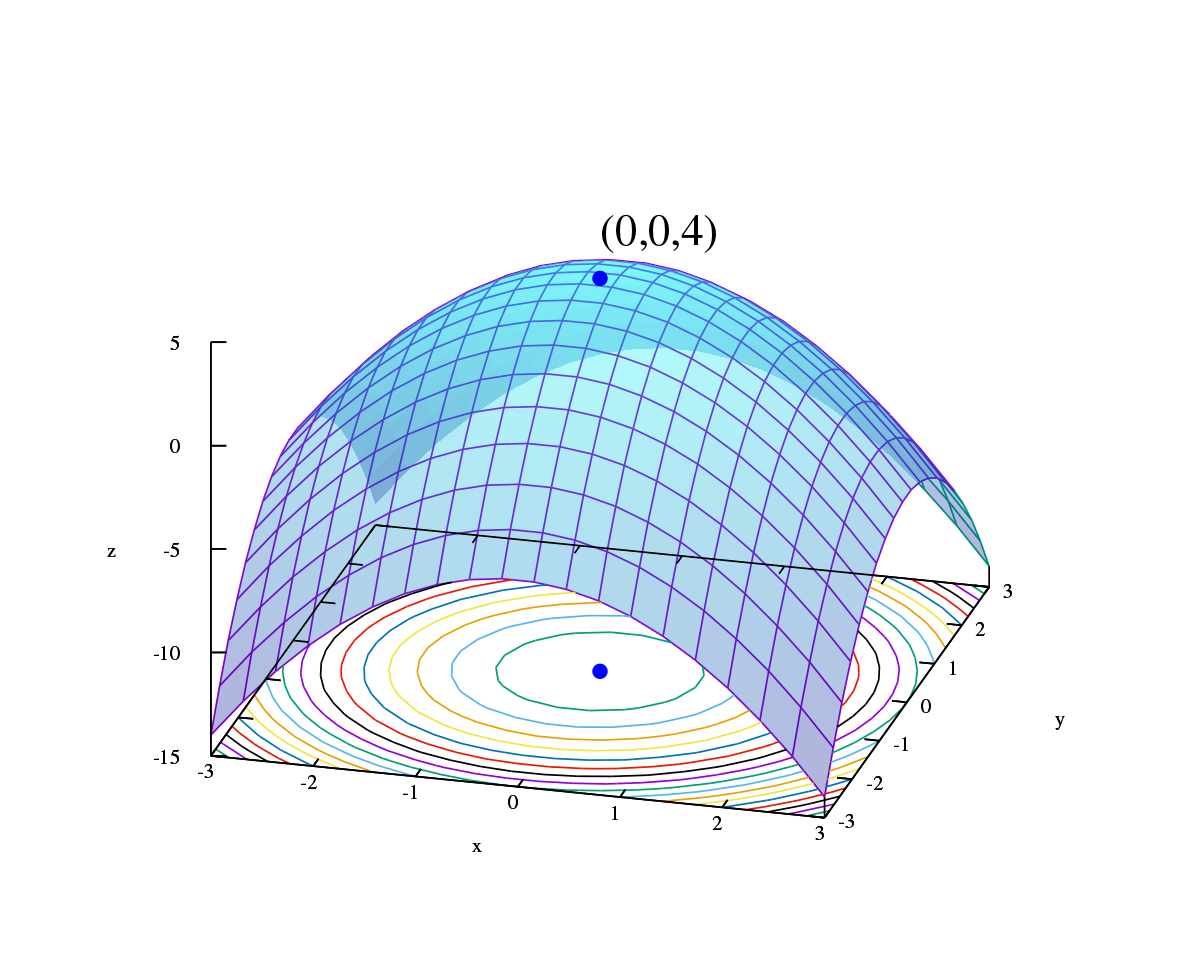 width="600"/>

Source: [Wikipedia](https://en.wikipedia.org/wiki/Mathematical_optimization#/media/File:Max_paraboloid.svg)
</div>


This graph depicts the surface given by $z = f(x, y) = (x^2 + y^2) + 4$. In this example, when maximizing this function, the point $(0, 0, 4)$ is the global optimum.
This example belongs to a class of problems called convex optimization (the line segment joining any two points on its graph lies above or on the graph). In such problems, local optimum are also global optimum, a class of problems that can be solved quite effectively. Unfortunately, not all problems can be formulated as convex optimization problems. Consider the following objective function:


<div>
<img src=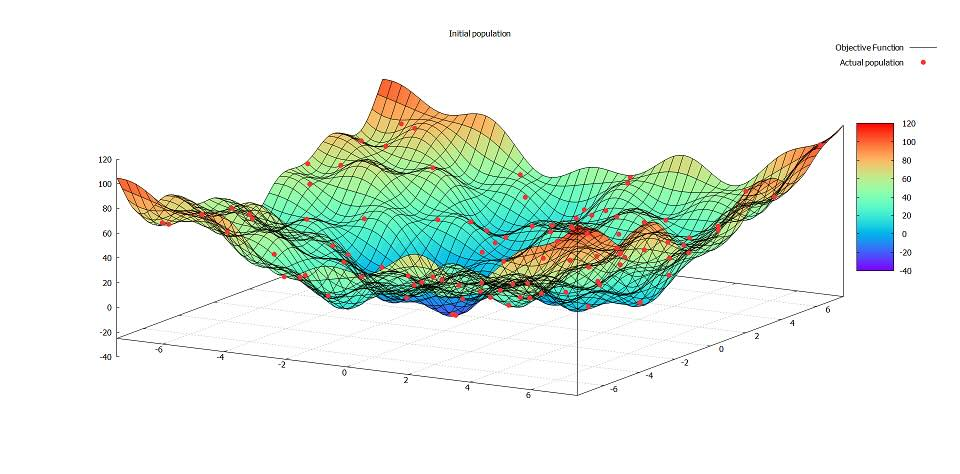 width=650/>
</div>

To find the global minimum of such a cost function the optimization method must be robust to getting stuck in local optimum.

### Solvers - Solving optimization problems
Once an optimization problem is formulated, an optimization method is necessary to solve the problem. The formulation of the optimization problem, problem size, and computational budget determine what solvers are appropriate. The choice of a solver typically involves trade-offs between guarantees of optimality, implementation effort, computational efficiency, and effort in formulating the optimization problem.

We will revisit this topic in the next section.

## Optimization in HCI
Now that we went through the key components of an optimization problem, what are **variables, objectives, and solvers** like when applying optimization to HCI problems?

To understand that, let's take an example problem, the placement of a UI element in Mixed Reality (MR), which we considered in the beginning. Consider an MR scenario where we want to create an interface to handle incoming calls. Where should the interface best pop up when the user receives a call?

You can use the following code to visualize the user and the interface.


In [10]:
%%capture
%matplotlib inline

!pip install ipython_genutils ipyvolume;
!pip install trimesh;
!pip install gdown;
!gdown "https://drive.google.com/uc?id=1nj-rPRlMavx1CTrUzUC571bplnfc6VN1" -O model.stl;

In [19]:
# imports // you can ignore this cell
import trimesh
import ipyvolume as ipv
import numpy as np
import warnings
import time

warnings.filterwarnings('ignore')

# This function plots virtual MR UI elements according to an array of their respective [x,y,z] positions
# e.g., plot_mr_scenario([[]])
def plot_mr_scenario(ui_properties, gaze=False):
    """
    Plot the MR scenario specified above.

    Parameters:
        ui_properties (array): position of the UI element and width of the UI element.
        gaze (boolean): Plot gaze line.

    Returns:
        float: Time (T) in seconds to hit the target.
    """
    # Load the model from (https://skfb.ly/n5k4i3fdc0) by onmioji
    # licensed under Creative Commons Attribution (http://creativecommons.org/licenses/by/4.0/).
    mesh = trimesh.load_mesh("model.stl")
    vertices = mesh.vertices
    faces = mesh.faces

    fig = ipv.figure()
    # Plot the 3D model
    vertices = vertices / 300 + [0.5, 1, 0]
    ipv.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=faces)
    # Plot the UI element
    for ui in ui_properties:
        ipv.plot_trisurf([ui[0]-ui[3]/2, ui[0]+ui[3]/2, ui[0]-ui[3]/2, ui[0]+ui[3]/2],
         [ui[1]-ui[3]/2, ui[1]+ui[3]/2, ui[1]+ui[3]/2, ui[1]-ui[3]/2], ui[2],
            triangles=[[0, 2, 3], [2, 3, 1]], color="blue")

    if gaze:
        x = 0.5
        y = 1.8
        z = np.linspace(0, 1, 100)
        ipv.plot(x, y, z, color='blue', size=2)

    ipv.pylab.xyzlabel("X [m]", "Y [m]", "Z [m]")

    ipv.show()

In [20]:
# plot scenario with UI element in front of the user
# receives a list of UI elements and their respective properties (position in 3D spac)
plot_mr_scenario([[0.5, 1.3, 0.6, 0.1]]);

Html(layout=None, style_='display: none', tag='span')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…


### Variables
Variables are the decisions you want to optimize for. In realistic HCI use cases, a variable will typically be a design decision or a property of a user interaction element that you want to optimize. Depending on your problem, these variables will typically take the form of:

- **real numbers**, such as the position of an element in continuous 2D or 3D space.
- **integers**, that could indicate the level of detail of a widget or the index of an element in a menu.
- **booleans**, for binary decisions, such as enabling or disabling a feature.

Questions:
### <font color="green"> Questions:</font>
<font color="green">*1. Consider the example from the beginning. What would the decision variable be?*</font>

<font color="green">*2. Pick an HCI problem in your research topic that you'd like to solve. What variables would that problem have?*</font>




### Objective functions
The objective function will determine what is a good solution to the problem. Depending on how it is formulated, you will solve a minimization (cost) or maximization (utility) problem. A term of a cost function can be about any property of your solution that is desired, such as usability aspects or performance metrics. There are different approaches to defining objective functions:

* **Heuristics** are rules of thumb used in design, such as "white space should be minimized". You might need multiple heuristics which might lead to the problem of conflict resolution: how to weigh the contribution of one heuristic against another.

* **Metrics** are numerical functions that link some feature of the design to predictions of the outcome for users. They can be in the form of look-up tables and can come from previously collected data or pre-computed from more complex models. Example: ergonomic metrics of fatigue

* **Regression** offers a more expressive yet quickly computable mathematical form of cost functions in the form y = f(x, β) + ϵ. Its parameters can be inferred at run-time e.g. to adapt to expertise of a specific user.

* **Black-box models** can be machine-learning-based models, such as neural networks or reinforcement learning-based simulations of user behavior that are able to consider both parameters of the user and those of the task or context. They may address multiple design objectives in a coherent manner that require less weight-tuning. However, they are non-linear and significantly more expensive to execute, ruling out exact methods (e.g, integer programming).

Objectives can be based on models from literature, or constructed from existing guidelines and design patterns. They can also be learned from data with machine learning methods.

An example of a popular objective function when optimizing user interfaces for performance is Fitt's Law, which we saw in the beginning:

$$MT = a + b \cdot \log_2 \left(\frac{D}{W} + 1\right)$$

In short, it predicts the time required to move to and select a target (*MT*), where *MT* is a function of the distance to the target *D* and the size of the target *W* and *a* and *b* are constants derived from empirical data.


### <font color="green"> Questions:</font>
<font color="green">*1. What type of objective function is this?*

<font color="green">*2. The following code implements the computation of the movement time. Use the plotting function to  play around with the different combinations of values for x, y, z, w. How does the cost change?*



In [21]:
def fitts_law(distance, width, a=0.1, b=0.4):
    """
    Calculate the time to hit a target using Fitts' Law.
    Note: Fitts' Law primarily considers movements in a two-dimensional plane, for mid-air interactions it might
    require adaptations and empirical adjustments to accurately model the performance of these interactions.

    Parameters:
        distance (float): Distance to the target (D).
        width (float): Width of the target (W).
        a (float): Empirically determined constant. Defaults to an unprincipled approximation for 3D movements.
        b (float): Empirically determined constant. Defaults to an unprincipled approximation for 3D movements.

    Returns:
        float: Time (T) in seconds to hit the target.
    """
    index_of_difficulty = np.log((distance / width) + 1)
    time = a + b * index_of_difficulty
    return time

# In our use case we consider the width of the button to accept the call to be 20% of the size of the UI element
def mt(x, y, z, w):
    """
    Compute the cost for a specific position and size of a UI element.
    """
    # Compute the Euclidean distance from end effector to UI (button to accept call is in the center)
    # End effector (right fingertip is at position (-0.1, 0, 0.1) in this example
    distance = np.linalg.norm(np.array([x, y, z]) - np.array([-0.1, 1, 0.1]))
    width = w / 0.2
    return fitts_law(distance, width)


In [22]:
# TODO: Play around with different combinations of values for x, y, z, w. How does the cost change?
x = 0.5,
y = 0.5,
z = 0.5,
w = 0.3
print(mt(x,y,z,w))
plot_mr_scenario([[0.5, 1.3, 0.6, 0.1]]);

0.3798992605022192


Html(layout=None, style_='display: none', tag='span')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…


### Problem formulation
Now we have defined Variables and a cost function. Let's write down the optimization problem.

\begin{align*}
\text{minimize} \quad & MT(x,y,z,w) \\
\text{subject to} \quad & x,y,z,w \in \mathbb{R}\\                  
\end{align*}

If this is our final formulation, the solution space will be unnecessarily large and include solutions that we do not want.
### <font color="green"> Question:</font>
<font color="green">*What can we do about that?*

### Constraints
The solution space of an optimization problem is determined by the variables and the constraints in its formulation. Formulating requirements, rules, and undesired solutions in your problem as additional constraints can improve solver efficiency and avoid invalid solutions.

In our scenario, we know that we want to place the UI in front of the user and at a reasonable distance so they can interact with it using their hands. The 2D UI element should also not be too small or too large so that the user is still able to see everything and interact with it comfortably. Thus, we add constraints for our variables, as follows:

\begin{align*}
\text{minimize} \quad & MT(x, y, z, w) \\
\text{subject to} \quad & x_1 \leq x \leq x_2 \\
\quad & y_1 \leq y \leq y_2 \\
\quad & z_1 \leq z \leq z_2 \\
\quad & w_1 \leq w \leq w_2 \\
\quad & x, y, z, w \in \mathbb{R}
\end{align*}

Note that the coordinate system used by ipyvolume is a right-handed coordinate system and we assume meters as the unit of measurement (see plot, x -> right, y -> up, z -> forward).

### <font color="green"> Question:</font>
<font color="green">*Use the plotting function to define reasonable values for our constraints*

In [24]:
# Define constraints for this specific problem. Replace the placeholders with
# actual values (use the plotting function for guidance)

constraints = [(x1, x2), (y1, y2), (z1, z2), (w1, w2)]

#Example values
#constraints = [(-0.2, 0.8), (1, 2), (0.1, 1), (0.1, 0.3)]

### Solver

Now that we have formulated an optimization problem with variables, cost function, and constraints, we need a method to solve it.

Here, we cover a non-exhaustive overview of properties of interest that solvers and objective functions can have (which affect the choice of solver). Having the ability to identify which classes are relevant to your problem can help you pick effective solvers for your use-case:
#### **Gradient**
**First/Second Order Methods:** Objective function must be differentiable; solvers that use gradient information to find solutions.

**Zero-Order Methods:** Solvers which do not use gradients, making them suitable for non-smooth, noisy, or black-box functions where gradient computation is not feasible.


---


#### **Solution**
**Exact:** Methods which guarantee a solution that is a global optimum once they terminate.

**Approximate:** Methods that provide an approximate solution which is close to the optimal but not necessarily exact. Some of these methods can get stuck in local optimum.


---


#### **Objective Function**
**Explicit functions**: Explicit functions have a clearly defined mathematical expression. Their structure, parameters, and relationships within the function are clearly defined.

**Black-box functions**: These functions have unknown or complex internal structures. They can only be evaluated through input-output pairs without insight into their internal mechanisms.


---



We will start with exhaustive search. Although this is quite a basic optimization method, extensions of exhaustive search have been used successfully in HCI. For example, [Supple](https://dl.acm.org/doi/abs/10.1145/964442.964461) uses branch and bound, which uses heuristics to prune suboptimal branches of the search space, while [XRgonomics](https://dl.acm.org/doi/10.1145/3411764.3445349) uses data structures for efficient retrieval of optimal solutions.

### <font color="green"> Question:</font>
<font color="green">*To which classes belongs the exhaustive search solver?*

The following code implements a function to exhaustively search through the space of feasible solution. For exhaustive search to work, we need to *discretize* the solution space into intervals which can be searched through.



In [25]:
def exhaustive_search_4d(cost_function, constraints, intervals):
    """
    Perform exhaustive search on a 4D domain.

    Args:
    - cost_function (function): A cost function that takes four integers and returns a value.
    - constraints (array of tuples): Constraints for the search space.
    - intervals (array of floats): Step / discretization.

    Returns:
    - best_cost: The best lowest cost found.
    - best_solution: The values [x, y, z, w] corresponding to the best solution.
    """
    best_cost = float('inf')  # Assuming we are looking for the minimum value.
    best_solution = None

    # Iterate over each dimension according to constraints and intervals.
    for x in np.arange(constraints[0][0], constraints[0][1], intervals[0]):
        for y in np.arange(constraints[1][0], constraints[1][1], intervals[1]):
            for z in np.arange(constraints[2][0], constraints[2][1], intervals[2]):
                for w in np.arange(constraints[3][0], constraints[3][1], intervals[3]):
                    current_cost = cost_function(x, y, z, w)
                    if current_cost < best_cost:
                        best_cost = current_cost
                        best_solution = [x, y, z, w]

    return best_cost, best_solution

*Note:* To use exhaustive search, we effectively turn the continous optimization problem formulated above into a discrete optimization problem. The variables are not continuous anymore but take integer values corresponding to the  discretized space. We then evaluate the cost of each value combination.

Let's now solve the problem and plot the best solution.

In [26]:
# discretization step per dimension
intervals = [0.05, 0.05, 0.05, 0.02]

#Let's time the solution process
start_time = time.time()
best_cost, best_solution = exhaustive_search_4d(mt, constraints, intervals)
end_time = time.time()

print(f"Optimization completed in {end_time - start_time:.3f}s. Best solution for x,y,z,w: {best_solution}, Cost: {best_cost}")

# Let's now plot the best solution
plot_mr_scenario([best_solution]);

Optimization completed in 0.544s. Best solution for x,y,z,w: [-0.10000000000000003, 1.0, 0.1, 0.1], Cost: 0.1


Html(layout=None, style_='display: none', tag='span')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

### <font color="green"> Question:</font>
<font color="green">*1. This solution does not look great. Why? What can we do to improve?*

<font color="green">*2. Try to discretize the solution space further by reducing the values in the interval array. What issue do you experience?*

## Multi-objective optimization
In our current formulation we are minimizing for movement time, but in most realistic HCI problems there are multiple aspects a designer must optimize for. In our MR scenario, usability aspects such as visibility and reachability of the interface (for hand input) are crucial. Let's revisit our formulation to consider both, the movement time and a cost for whether the element is in the field of view of the interface:


\begin{align*}
\text{minimize} \quad & \left[ \begin{aligned}
& MT(x, y, z, w) \\
& FoV(x, y, z, w)
\end{aligned} \right] \\
\text{subject to} \quad & 0 \leq x \leq \frac{x_2-x_1}{I_x} \\
\quad & 0 \leq y \leq \frac{y_2-y_1}{I_y} \\
\quad & 0 \leq z \leq \frac{z_2-z_1}{I_z} \\
\quad & 0 \leq w \leq \frac{w_2-w_1}{I_w} \\
\quad & x, y, z, w \in \mathbb{Z}
\end{align*}


### <font color="green"> Question:</font>
<font color="green">*1. How would you implement a cost function to optimize for visibility?*

<font color="green">*2. Play around with the implementation below. Change the values of x,y,z,w and notice how it affects the cost.*




In [27]:
def fov_cost(x,y,z,w):
    """
    Compute the cost based on the position of a UI element in the user's field of view.

    Returns:
        float: Cost.
    """
    # transform our point according to the position of the user's head
    ui_pos = np.array([x, y, z]) - np.array([0.5, 1.8, 0])
    # in our scenario the user is facing the z axis, therefore, we want to compute the angle according to the "forward" vector (0, 0, 1)
    gaze = np.array([0, 0, 1])

    # compute the angle
    dot_product = np.dot(ui_pos, gaze)
    norm1 = np.linalg.norm(ui_pos)
    norm2 = np.linalg.norm(gaze)
    if norm1 * norm2 <= 0:
        cost = 0
    else:
        cos_angle = dot_product / (norm1 * norm2)
        angle_radians = np.arccos(cos_angle)
        cost = np.degrees(angle_radians)

    return cost


In [28]:
# TODO: change the values of x, y, z, w and notice how it affects the cost
x, y, z, w = 0, 1.8, 0.3, 0.2
print(f"Field of View Cost: {fov_cost(x, y, z, w)}")
plot_mr_scenario([[x, y, z, w]]);

Field of View Cost: 59.03624346792648


Html(layout=None, style_='display: none', tag='span')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…


#### Solving multi-objective problems
<font color="green">*Can we solve this problem using the solver above? Why or why not?*

Having multiple objectives brings additional challenges. In such formulations, it is often the case that it is impossible to improve on one objective without deteriorating another. Therefore, when solving for a single solution, the developer/designer must articulate preferences in terms of the relative importance objectives. This can be done in various ways (refer to the survey of [Marler and Arora](https://link.springer.com/article/10.1007/s00158-003-0368-6)), but one of the most pre-dominant techniques to do so in HCI is to use the weighted sum method:
$$C_x = \sum_{j=1}^k w_i \cdot F_i(x)$$
where $C_x$ is the cost of solution $x$, calculated by summing the products of weights $w_i$ and respective cost functions $F_i$ for each $k$ criterion $i$.

### <font color="green">Questions:
<font color="green">*1. Change the optimization formulation above to minimze a weighted sum*

<font color="green">*2. Define different values for the weights and see how that affects the optimal solution. What do you notice?*

In [30]:
def weighted_sum_cost_function(x, y, z, w):
    # TODO: define values for the weights and see how that affects the optimal solution.
    # What do you notice? Can you improve on it?
    w1, w2 = 1, 0.01
    return w1 * mt(x,y,z,w) + w2 * fov_cost(x,y,z,w)

constraints = [(-0.2, 0.8), (1, 2), (0.4, 1), (0.06, 0.1)]
intervals = [0.05, 0.05, 0.05, 0.04]

best_cost, best_solution = exhaustive_search_4d(weighted_sum_cost_function, constraints, intervals)

print(best_cost)
plot_mr_scenario([best_solution]);

0.5510173934315468


Html(layout=None, style_='display: none', tag='span')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

It is difficult to find a good combination of weights that nicely trade-off between ergonomics and visibility, right? Having cost functions of different scales makes it harder.

### <font color="green">Questions:
<font color="green">*Why do you think this is the case?*

<font color="green">*Optional: Normalize the two cost functions to make them comparable*


### Pareto Optimality
When solving multi-objective optimization problems, it is often the case that we cannot fullfill one objective without making at least one other objective worse off. As a result, there are multiple solutions that can all be considered optimal: those for which there exists no other solution that would be better with respect to each objective term. We refer to such solutions as pareto-optimal, and the combination of all of these is called the pareto frontier. Using approaches such as the weighted-sum method limits which solutions one can achieve, depending of the formulation of optimization problem. For example, the shape of the pareto frontier affects what optimal solutions are possible to obtain when using the weighted sum method. See the figure below from our [paper](https://dl.acm.org/doi/abs/10.1145/3586183.3606799) that illustrates this:

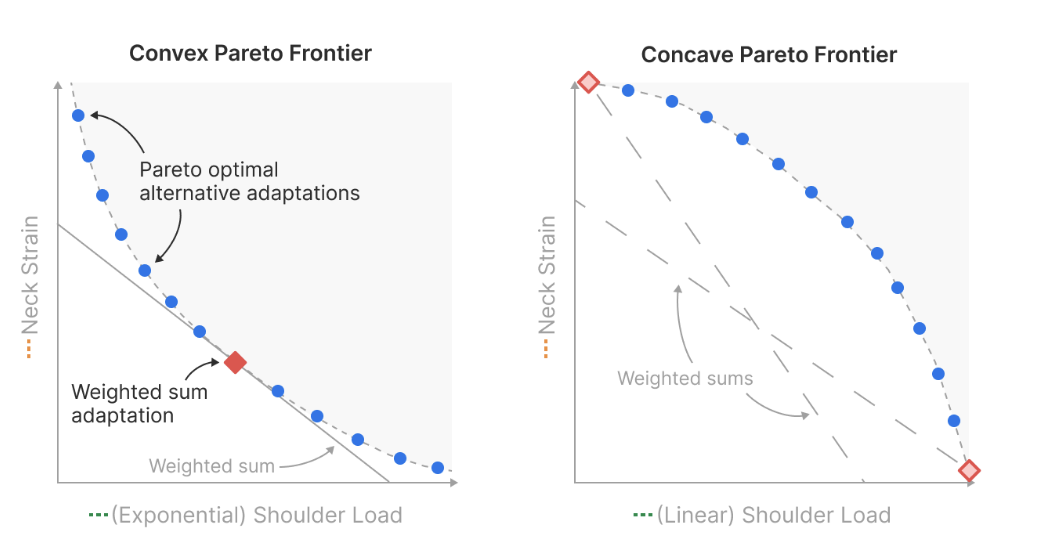

Now, let's update our solver so we can retrieve the pareto frontier for our two objectives:

<font color:"red">TODO I suggest that you change the implementation slightly to make the two cost terms separate arguments rather than clumping them into the same list, this makes it easier to understand and makes the extension more obvious

In [31]:
def exhaustive_search_4d_pareto(cost_functions, constraints, intervals):
    """
    Perform exhaustive search on a 4D domain.

    Args:
    - cost_function (function): A cost function that takes four integers and returns a value.
    - constraints (array of tuples): Constraints for the search space.
    - intervals (array of floats): Step / discretization.

    Returns:
    - best_cost: The best lowest cost found.
    - best_solution: The values [x, y, z, w] corresponding to the best solution.
    """
    best_cost = float('inf')  # Assuming we are looking for the minimum value.
    best_solution = None
    x_dim = np.arange(constraints[0][0], constraints[0][1], intervals[0])
    y_dim = np.arange(constraints[1][0], constraints[1][1], intervals[1])
    z_dim = np.arange(constraints[2][0], constraints[2][1], intervals[2])
    w_dim = np.arange(constraints[3][0], constraints[3][1], intervals[3])

    costs = np.empty([x_dim.shape[0] * y_dim.shape[0] * z_dim.shape[0] * w_dim.shape[0], 2])
    solution = []
    i = 0

    # Iterate over each dimension according to constraints and intervals.
    for x in x_dim:
        for y in y_dim:
            for z in z_dim:
                for w in w_dim:
                    costs[i][0] = cost_functions[0](x, y, z, w)
                    costs[i][1] = cost_functions[1](x, y, z, w)
                    solution.append((x, y, z, w))
                    i += 1

    # Find the non_dominated points
    non_dominated = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if non_dominated[i]:
            non_dominated[non_dominated] = np.any(costs[non_dominated]<c, axis=1)  # Keep points with a lower cost
            non_dominated[i] = True

    pareto_front = []
    idx = np.nonzero(non_dominated)
    for i in idx[0]:
        pareto_front.append([solution[i], costs[i]])
    return pareto_front

Let's use this function to compute the pareto frontier and visualize it.

In [33]:
constraints = [(-0.2, 0.8), (1, 2), (0.2, 1), (0.06, 0.1)]
intervals = [0.05, 0.05, 0.05, 0.04]

start_time = time.time()
pareto_front = exhaustive_search_4d_pareto([mt, fov_cost], constraints, intervals)
end_time = time.time()

print(f"Optimization completed in {end_time - start_time:.3f}s.")

#Visualize all found solutions
solutions = []
for p in pareto_front:
    solutions.append(p[0])

plot_mr_scenario(solutions);

Optimization completed in 1.687s.


Html(layout=None, style_='display: none', tag='span')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

### <font color="green"> Question:</font>

<font color="green">*1. Is this what you expected? Which solution would you prefer?*

<font color="green">*2. Increase the discretization of the solution space. What do you notice?*

### Solving our optimization problem faster
If we increase the dimensions (e.g., by adding more UI elements, or design options) exhaustive search is not going to be efficient enough for real-time scenarios like online MR adaptations.

Thus, we are going to turn to another class of solvers: approximate methods, which are often based on **random search**. The basic idea is that instead of systematically and exhaustively going through the whole design space, we will randomly pick the next solution to evaluate. This will not guarantee to find the global optimium but can provide an approximate and good enough solution more quickly. Ranodm search can be made more efficient by employing smart search strategies.

**Meta-heuristic** methods are high-level frameworks that employ strategies to explore and exploit the search space of complex optimization problems, to find near-optimal solutions efficiently. They generally involve iterative processes and guided randomness to balance between intensification (exploiting known good solutions) and diversification (exploring new regions of the search space), aiming to converge to a globally optimal or satisfactory solution over time.

Here, we will introduce you to **genetic algorithms**. This meta-heuristic algorithm has the advantage of being highly parallelizable and having many variants that you can look into depending on your specific needs. We provide you with a basic implementation tailored to our scenario. Note that this implementation is simplified, there are opportunities to improve on its efficiency!

Intuitively, genetic algorithms are inspired by the process of natural selection. They go through the following steps:

* *Initialization*: Generate an initial population of random solutions (genomes).
* *Evaluation*: Assess the fitness of each solution using the fitness function.
* *Selection*: Select pairs of solutions based on their fitness.
* *Crossover*: Perform crossover to produce new solutions (offspring).
* *Mutation*: Apply mutation to some offspring.
* *Replacement*: Form a new population, often replacing the least fit solutions.
* *Termination*: Repeat the process until a stopping criterion is met (e.g., a solution is found or a maximum number of generations is reached).

[Pseudo code](https://en.wikipedia.org/wiki/Genetic_algorithm)

In [52]:
# Parameters
population_size = 200
mutation_rate = 0.5
crossover_rate = 0.7
num_generations = 100

constraints = [(-0.2, 0.8), (1, 2), (0.2, 1), (0.06, 0.1)]

initial_population = np.array([
    np.random.uniform(low=constraints[0][0], high=constraints[0][1], size=10000),
    np.random.uniform(low=constraints[1][0], high=constraints[1][1], size=10000),
    np.random.uniform(low=constraints[2][0], high=constraints[2][1], size=10000),
    np.random.uniform(low=constraints[3][0], high=constraints[3][1], size=10000),
]).T

def non_dominated_solutions(fitnesses):
    # Find the non_dominated points
    non_dominated = np.ones(fitnesses.shape[0], dtype = bool)
    for i, c in enumerate(fitnesses):
        if non_dominated[i]:
            non_dominated[non_dominated] = np.any(fitnesses[non_dominated]<c, axis=1)  # Keep points with a lower cost
            non_dominated[i] = True
    return non_dominated


def fitness(genome):
    return np.array([mt(*genome), fov_cost(*genome)])


# select non-dominated solutions
def selection(population):
    fitnesses = np.array([fitness(individual) for individual in population])
    non_dominated = non_dominated_solutions(fitnesses)

    pareto_front = []
    idx = np.nonzero(non_dominated)
    pareto_front = population[idx]

    return pareto_front


def crossover(parent1, parent2):
    if np.random.rand() < crossover_rate:
        point = np.random.randint(1, 4)
        return np.concatenate([parent1[:point], parent2[point:]]), np.concatenate([parent2[:point], parent1[point:]])
    else:
        return parent1, parent2


# mutate one value in the solution at random
def mutate(genome):
    if np.random.rand() < mutation_rate:
        idx = np.random.randint(0, 4)
        genome[idx] = np.random.uniform(low=constraints[idx][0], high=constraints[idx][1])
    return genome

def run_genetic_algorithm_solver():
    population = initial_population
    # run the genetic algorithm
    for generation in range(num_generations):
        # Selection
        selected = selection(population)

        # Crossover
        offspring = np.empty([population_size, 4])
        for i in range(0, population_size, 2):
            offspring1, offspring2 = crossover(selected[np.random.randint(0, selected.shape[0])], selected[np.random.randint(0, selected.shape[0])])
            offspring[i] = offspring1
            offspring[i+1] = offspring2

        # Mutation
        population = np.array([mutate(individual) for individual in offspring])

        # Evaluate best solution (Pareto front)
        pareto_front = selection(population)

        return pareto_front



In [53]:
start_time = time.time()
pareto_front = run_genetic_algorithm_solver()
end_time = time.time()

print(f"Optimization completed in {end_time - start_time:.3f}s.")

Optimization completed in 0.344s.


In [54]:
solutions = []
for p in pareto_front:
    solutions.append(p)

plot_mr_scenario(solutions);

Html(layout=None, style_='display: none', tag='span')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

### <font color="green"> Question:</font>

<font color="green">*What are your thoughts on this results? How can you prioritize speed or quality of solutions with such an approach?*

Note: the genetic algorithm does not require any discretization of the search space and it solves the continuous optimization problem with initially formulated.

## Conclusion

So far we went over three crucial components of an optimization problem for adapting user interfaces in MR: **objective functions**, **solvers**, and **variables**. However, there are more aspects one must consider when designing real-time adaptations. If you want to learn more check our [AUIT toolkit](https://dl.acm.org/doi/abs/10.1145/3526113.3545651), a Toolkit for Designing XR Applications.

Before proceeding to a final more open ended exercise, we leave you a (non-exhaustive) list of interesting optimization methods you can explore further, depending on the problem you want to solve:
- **Branch and bound**: technique for solving optimization problems that systematically explores potential solutions (branches), pruning off entire branches when heuristics signal they cannot contain a better solution than the best one already found.
- **(Integer) Linear Programming**: Method to achieve the best outcome in a mathematical model whose requirements and objective are represented by linear relationships. Certain algorithms guarantee optimality.
- **Metaheuristic Methods**: high-level algorithmic frameworks with strategies to guide the search process for finding near-optimal solutions to optimization problems, often inspired by natural phenomena or biological processes, in this case the physical annealing process.
- **Gradient-Descent Method**: Iterative algorithm that minimizes a function by repeatedly taking steps in the direction of its negative gradient. Well known for its usage for optimizing neural networks.
- **Quasi-Newton Methods**: technique that approximates the Hessian matrix (second-order derivative information) to find optimal solutions more efficiently than the traditional Newton's method.
- **Interior-Point Methods**: method for solving linear and non-linear convex optimization problems by iteratively moving through the interior of the feasible region, guided by a barrier function that keeps the solutions away from the boundaries.
- **Bayesian Optimization**: sequential technique for global optimization of black-box functions learned from sampling and from past evaluations.
- **Reinforcement Learning**: Method of optimal control where an agent learns to make decisions in an environment by maximizing a reward signal based on trial-and-error interactions.

More in the [slides](https://github.com/CIX24-UNILU/CIXSummerSchool2024/blob/616d70b16fdc41dedf14a8df164eef0fdb571ad0/Day_2_Lecture_1_Feit_Bello/CIXSchool24_Optimization_%20Motivation%20and%20Conclusion.pdf)

# <font color="green"> Exercise:</font>

<div>
<img src=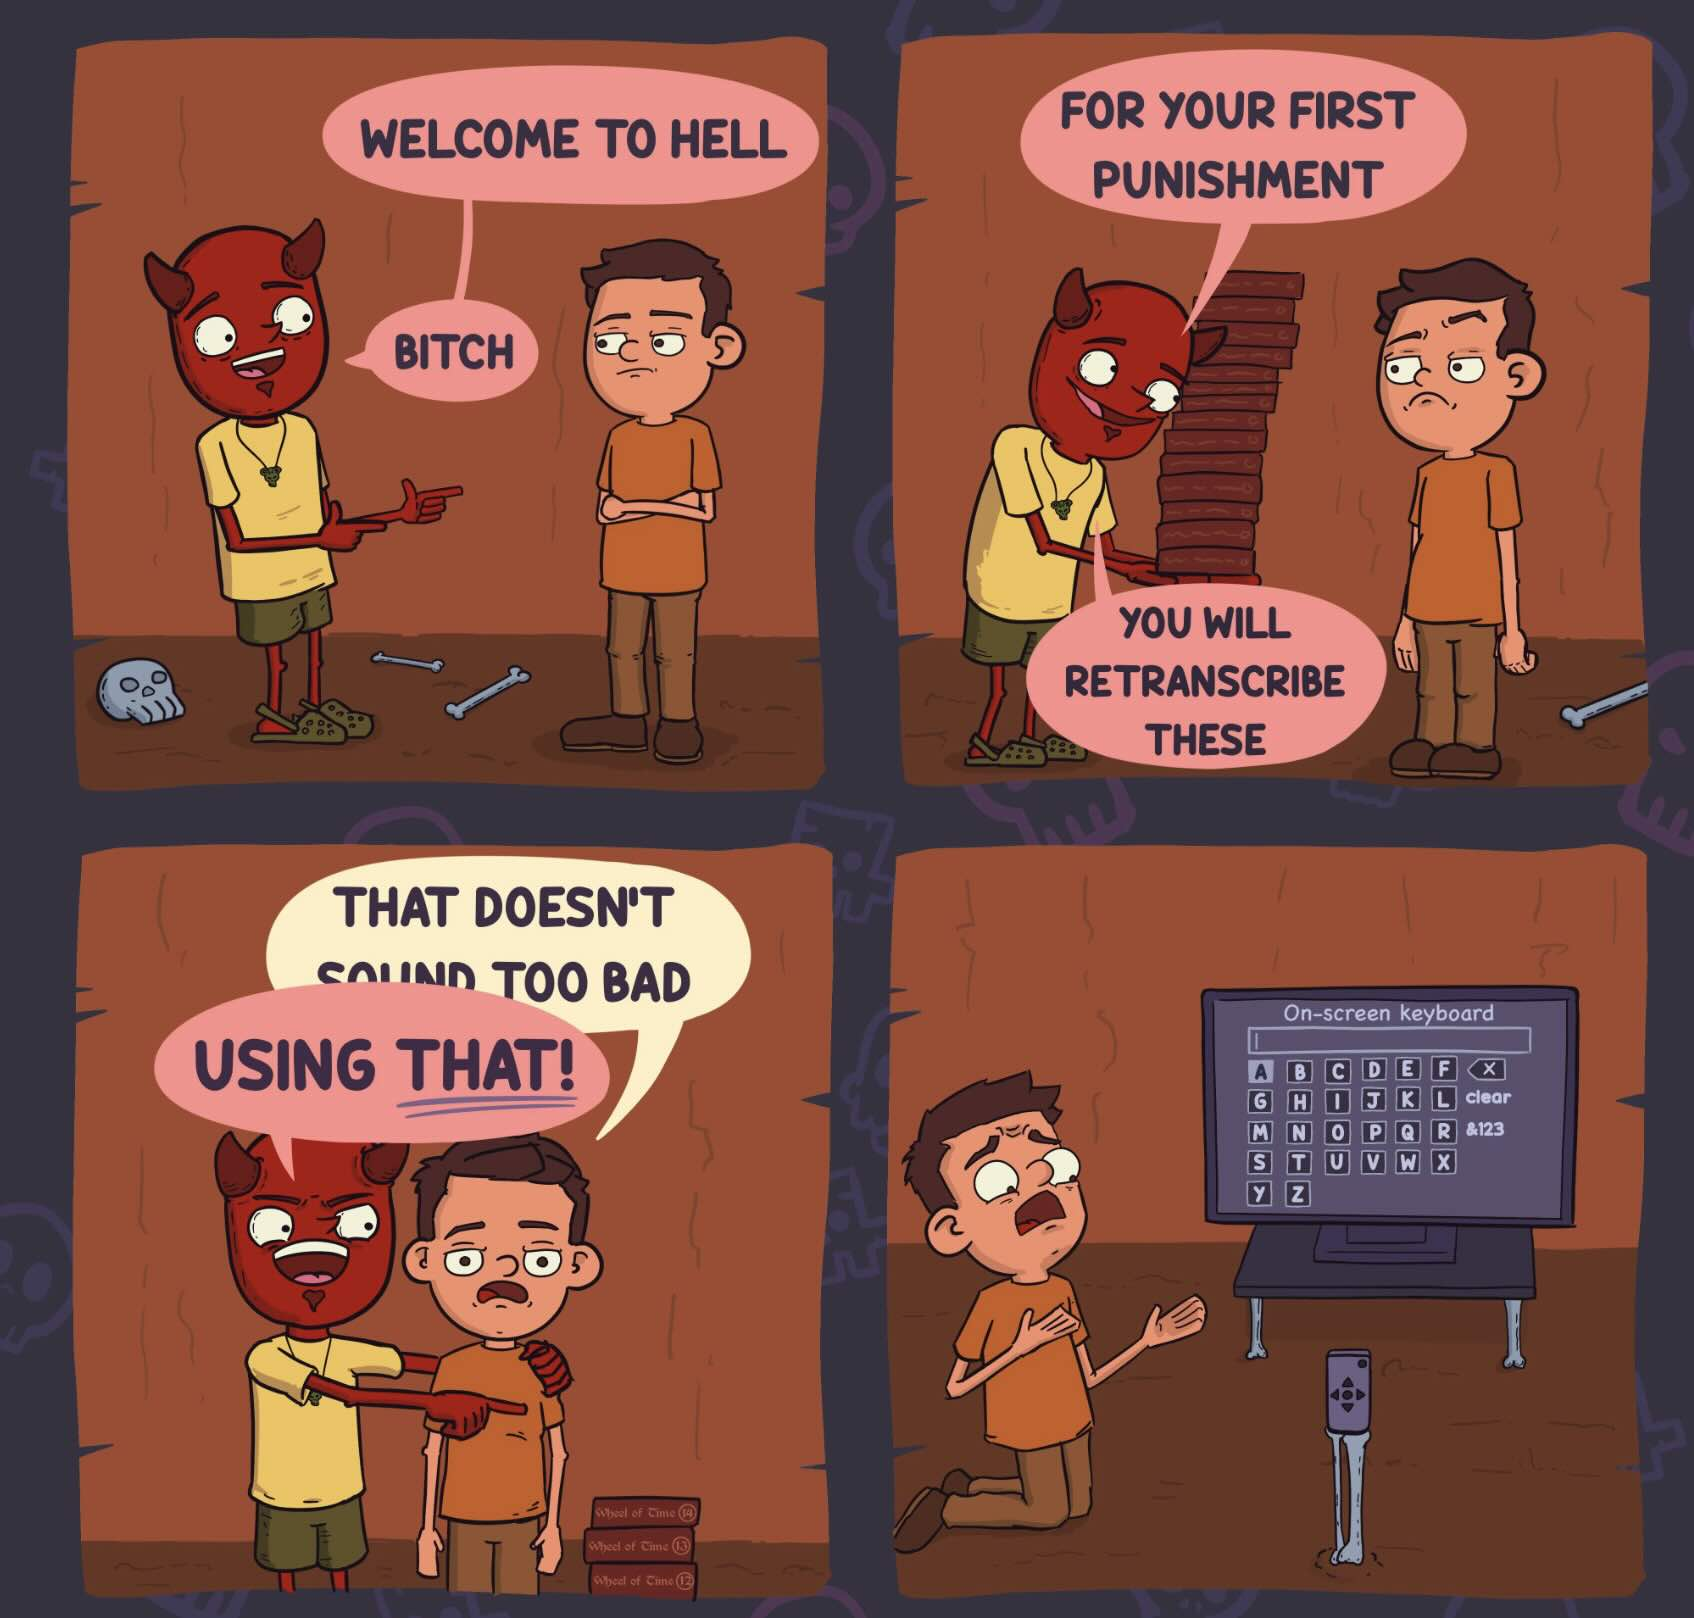 width=600/>
</div>

Now you will have the chance to put into practice the concepts that we covered so far to solve a fundamental interaction problem in HCI: the keyboard assignment problem.

Given a black-box objective function that simulates a user typing on a keyboard by direct touch (which combines Fitt's law with a typing error model), your task is to find a keyboard design where the simulated user achieves higher typing performance than with the baseline keyboard.

The following code showcases how you can change the size of the keyboard and the arrangement of keys.

Credit to [Yi-Chi Liao](https://yichiliao.com/) for the base code for this typing simulator.

### <font color="green"> Tasks:</font>

<font color="green">*Basic: 1. Formulate an optimization problem to find the best size of the keys. What are suitable constraints? How can you discretize the space?*

<font color="green">*Basic: 2. Use the exhaustive search method to find the best size of the keys based on the user simulation.*

<font color="green">*Advanced: 3. Implement a genetic algorithm to find the best keyboard layout. Think about, what are suitable crossover and mutation functions? Can you beat the QWERTY layout?*

In [1]:
%%capture
!pip install wonderwords pygame scipy imageio imageio-ffmpeg;
!gdown "https://drive.google.com/uc?id=16aaqm4mzG_YpshxNVRy-xhLYgnZffMhW" -O utils.py;

import numpy as np
from utils import KEYBOARD, get_highest, keyboard_sampler, weight_sampler_1d, get_target_sentence_wonderwords, get_grid, highest_value_each_iteration


In [2]:
# With the above values, we can now simulate the typing performance of individual users
keyboard = KEYBOARD()

In [11]:
# we have two design objectives, one for performance, another for errors
# in this formulation, we want to MAXIMIZE both!
# define the weights for both objectives:
keyboard.set_weights([0.5, 0.5])

In [22]:
# let's create different designs and evalute user typing.

# You can adjust the size of each key (in mm) by using this function:
# assign_key_dim([key_width, key_height])
keyboard.assign_key_dim([40, 70])

In [23]:
from IPython.display import HTML
from base64 import b64encode
# To view the new design, use render_keyboard. It basically reads the python
# dictionary of the keyboard and plays the simulation of the users.
# rendering_duration is an optional argument; unit is second.
keyboard.render(render_duration=1)

# Display the video in the notebook
def display_video():
    video_file = open("pygame_video.mp4", "rb")
    video_encoded = b64encode(video_file.read()).decode()

    # Create an HTML string with embedded video
    video_html = f'''
    <video width=400 controls>
        <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
    </video>
    '''

    # Display video in the notebook
    display(HTML(video_html))

display_video()

===== Rendering keyboard.


In [27]:
# check how different key dimensions change the results!
keyboard.assign_key_dim([20, 20])

# char_limit deteremines how many characters are going to be included for each user evaluation.
# Intuitively, more characters lead to a more stable evaluation result because it is average over more keystrokes.
char_limit = 500

# Now, let's evaluate the keybaord design.
# First, we create a sentence from the most common English words.
sentence = get_target_sentence_wonderwords(char_limit)

#print(sentence)

# Then, we evaluate it by using "evaluate" function.
# If you set render=True, a visualization of the typing will show
weighted_sum_result, individual_result, original_result = keyboard.evaluate(sentence, render=False)
print("The weighted sum result : ", round(weighted_sum_result,3))
print("The speed metric : ", round(individual_result[0], 3), "; the accuracy metric : ", round(individual_result[1], 3))
print("The original average movement time (s) : ", round(original_result[0],3), "; the original error rate : ", round(original_result[1],3))

The weighted sum result :  0.586
The speed metric :  0.357 ; the accuracy metric :  0.816
The original average movement time (s) :  0.284 ; the original error rate :  0.092


In [29]:
# Let's simulate typing a short sentence

sentence = "hello world"

weighted_sum_result, individual_result, original_result = keyboard.evaluate(sentence, render=True, render_duration=10)
print("The weighted sum result : ", round(weighted_sum_result,3))
print("The speed metric : ", round(individual_result[0], 3), "; the accuracy metric : ", round(individual_result[1], 3))
print("The original average movement time (s) : ", round(original_result[0],3), "; the original error rate : ", round(original_result[1],3))

display_video()

===== Rendering keyboard.
The weighted sum result :  0.519
The speed metric :  0.22 ; the accuracy metric :  0.818
The original average movement time (s) :  0.298 ; the original error rate :  0.091


In [ ]:
# You can also change the key assignment by swapping a pair of keys at a time.
# Use swap_keys() function
keyboard.swap_keys('q', 'e')
keyboard.swap_keys('a', 'b')

In [ ]:
keyboard.render(render_duration=1)
# Display the video in the notebook
display_video()

===== Rendering keyboard.


In [ ]:
# Note that you can continue swap keys. For instance, if you swap q <--> e and a <--> b, again,
# the keyboard will return to the original qwerty layout.
# remember that the keyboard design is stored as json file.
keyboard.swap_keys('q', 'e')
keyboard.swap_keys('a', 'b')
keyboard.render(render_duration=1)
display_video()

===== Rendering keyboard.


In [61]:
import pprint
# keyboard details can be changed directly in the keyboard_details dictionary
# each key in the dictionary corresponds to the key with that letter in a us-us layout
# you can also change the letter assigned to it by modifying its char value
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(keyboard.keyboard_details)

{   ' ': {'char': ' ', 'height': 70, 'width': 214, 'x': 59.5, 'y': 251.0},
    ',': {'char': ',', 'height': 70, 'width': 25, 'x': 221.5, 'y': 179.0},
    '.': {'char': '.', 'height': 70, 'width': 25, 'x': 248.5, 'y': 179.0},
    'a': {'char': 'a', 'height': 70, 'width': 25, 'x': 20.0, 'y': 107.0},
    'b': {'char': 'b', 'height': 70, 'width': 25, 'x': 140.5, 'y': 179.0},
    'c': {'char': 'c', 'height': 70, 'width': 25, 'x': 86.5, 'y': 179.0},
    'd': {'char': 'd', 'height': 70, 'width': 25, 'x': 74.0, 'y': 107.0},
    'e': {'char': 'e', 'height': 70, 'width': 25, 'x': 66.5, 'y': 35.0},
    'f': {'char': 'f', 'height': 70, 'width': 25, 'x': 101.0, 'y': 107.0},
    'g': {'char': 'g', 'height': 70, 'width': 25, 'x': 128.0, 'y': 107.0},
    'h': {'char': 'h', 'height': 70, 'width': 25, 'x': 155.0, 'y': 107.0},
    'i': {'char': 'i', 'height': 70, 'width': 25, 'x': 201.5, 'y': 35.0},
    'j': {'char': 'j', 'height': 70, 'width': 25, 'x': 182.0, 'y': 107.0},
    'k': {'char': 'k', 'height'

Now its up to you! Now you can try a entirely new solver such as bayesian optimization to quickly find the right keyboard dimensions for a specific user. If you are interested in what we have done and eager to do research on related topics reach you can always reach out to us :)